In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy
import scipy.io
import soundpy as sp
import sounddevice

speech_data = scipy.io.loadmat('project1.mat')
fs = speech_data['fs'][0]
speech_desired = speech_data['reference'][0]
speech_noisy = speech_data['primary'][0]

# Normalization
# wav = wav / np.sqrt(np.sum(wav ** 2))

In [3]:
sounddevice.play(speech_data['primary'][0], fs)

In [4]:
sounddevice.play(speech_data['reference'][0], fs)

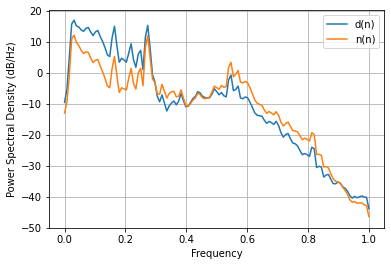

In [5]:
l1 = plt.psd(speech_desired)
l2 = plt.psd(speech_noisy)
plt.legend(['d(n)','n(n)'])

In [6]:
# Plot Performance Surface Contour

num_weight = 50
w1 = np.linspace(0, 2, num_weight)
w2 = np.linspace(0, 2, num_weight)
weight_w1, weight_w2 = np.meshgrid(w1, w2)
error_surface = np.zeros((num_weight, num_weight))
for i in range (num_weight):
    for j in range (num_weight):
        error_array = [speech_desired[k] - np.dot(np.array([weight_w1[i][j], weight_w2[i][j]]), speech_noisy[k-1:k+1]) for k in range (1, len(speech_noisy))]
        error_surface[i, j] = np.sqrt(np.sum(np.array(error_array) ** 2)/np.sum(speech_desired ** 2))
        

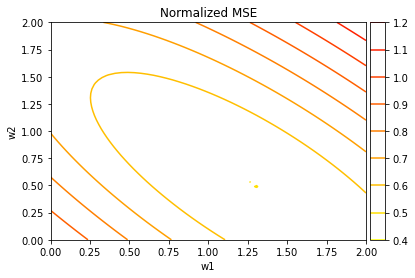

In [7]:
# plot 2D contour

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.gca()
cf = ax.contour(weight_w1, weight_w2, error_surface, cmap = 'autumn_r') # contour, plt draw, scale, optimization
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Normalized MSE')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)
plt.show()

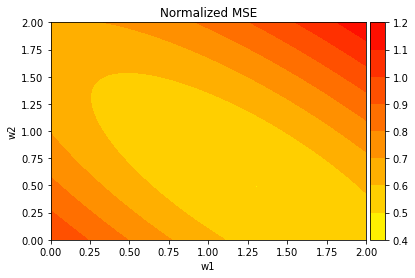

In [8]:
# plot 2D contourf

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.gca()
cf = ax.contourf(weight_w1, weight_w2, error_surface, cmap = 'autumn_r') # contour, plt draw, scale, optimization
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Normalized MSE')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)
plt.show()

In [31]:
# NLMS Algorithm, start (n-order:n, n-order+1:n+1)

filter_order = 2

weight_filter = np.zeros((filter_order))

step_size = 0.05 # step_size

weight_store = []
error_store = []

for n in range (filter_order-1, speech_desired.shape[0]):
    e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
    weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
    weight_store.append(weight_filter)
    y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
    error_store.append(y_error)
    
weight_store = np.array(weight_store)
error_store = np.array(error_store)


# Calculate ERLE
ERLE = 10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2))
ERLE

5.272644076018046

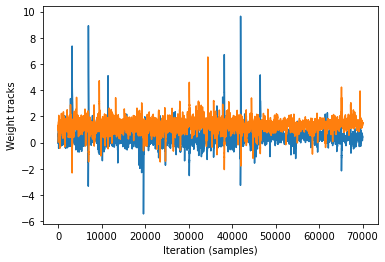

In [32]:
# weight filter_order = 2
plt.plot(np.arange(len(weight_store)), weight_store)
plt.xlabel('Iteration (samples)')
plt.ylabel('Weight tracks')
plt.show()

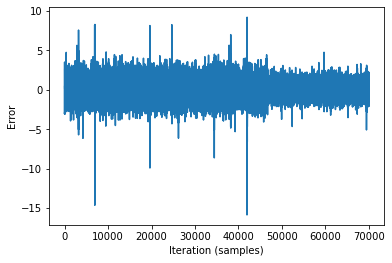

Mean of Error 0.027504237517384067
Std of Error 1.1129571769472169


In [33]:
# error filter_order = 2
plt.plot(np.arange(len(error_store)), error_store)
plt.xlabel('Iteration (samples)')
plt.ylabel('Error')
plt.show()
print('Mean of Error', np.mean(error_store))
print('Std of Error', np.std(error_store))

In [34]:
# NLMS Algorithm, start (n-order:n, n-order+1:n+1)

filter_order = 10

weight_filter = np.zeros((filter_order))

step_size = 0.05 # step_size

weight_store = []
error_store = []

for n in range (filter_order-1, speech_desired.shape[0]):
    e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
    weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
    weight_store.append(weight_filter)
    y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
    error_store.append(y_error)
    
weight_store = np.array(weight_store)
error_store = np.array(error_store)


# Calculate ERLE
ERLE = 10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2))
ERLE

18.949848292192556

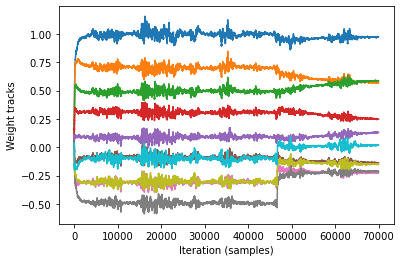

In [35]:
# weight
plt.plot(np.arange(len(weight_store)), weight_store)
plt.xlabel('Iteration (samples)')
plt.ylabel('Weight tracks')
plt.show()

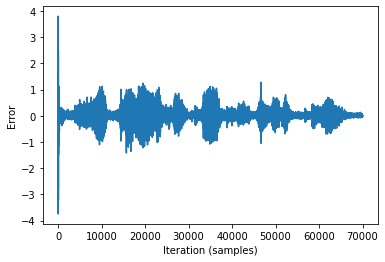

Mean of Error 0.016907149109869783
Std of Error 0.22991520485865014


In [36]:
# error
plt.plot(np.arange(len(error_store)), error_store)
plt.xlabel('Iteration (samples)')
plt.ylabel('Error')
plt.show()
print('Mean of Error', np.mean(error_store))
print('Std of Error', np.std(error_store))

In [37]:
# The filter performance as a function of step size

filter_order = 10
weight_filter = np.zeros((filter_order))
stepsize_array = np.logspace(-3, 2, 30)

ERROR_store = []
ERLE_store = []
WEIGHT_store = []

for step_size in stepsize_array: # step_size

    error_store = []

    for n in range (filter_order-1, speech_desired.shape[0]):
        e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
        weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
        y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
        error_store.append(y_error)
        
    error_store = np.array(error_store)
    ERROR_store.append(np.sqrt(np.sum(error_store ** 2)/np.sum(speech_desired ** 2)))
    ERLE_store.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2)))
    WEIGHT_store.append(weight_filter)


C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_32352/1610264983.py:17: RuntimeWarning: overflow encountered in multiply
  weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_32352/1610264983.py:17: RuntimeWarning: invalid value encountered in add
  weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_32352/1610264983.py:22: RuntimeWarning: overflow encountered in square
  ERROR_store.append(np.sqrt(np.sum(error_store ** 2)/np.sum(speech_desired ** 2)))
C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_32352/1610264983.py:23: RuntimeWarning: overflow encountered in square
  ERLE_store.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_s

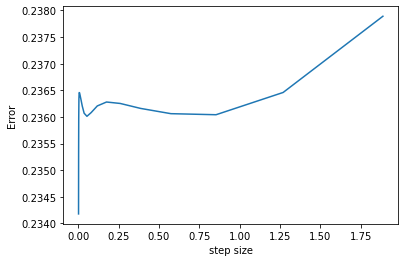

In [40]:
ERROR_opt_weight = []
ERLE_opt_weight = []
for i in range(len(stepsize_array)):
    error_opt_weight = []
    for n in range (filter_order-1, speech_desired.shape[0]):
        error_opt_weight.append(speech_desired[n] - np.dot(WEIGHT_store[i], speech_noisy[n-filter_order+1:n+1][::-1]))
    error_opt_weight = np.array(error_opt_weight)
    ERROR_opt_weight.append(np.sqrt(np.sum(error_opt_weight ** 2)/np.sum(speech_desired ** 2)))
    ERLE_opt_weight.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_opt_weight ** 2)))
    
# Plot ERROR by stepsize
plt.plot(stepsize_array, ERROR_opt_weight) # ERROR_opt_weight, ERROR_store
plt.xlabel('step size')
plt.ylabel('Error')
plt.show()

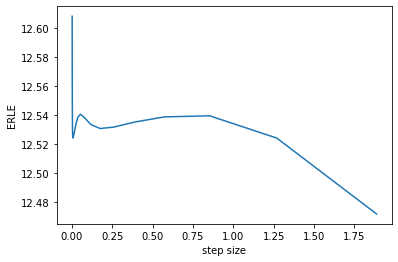

In [41]:
# Plot ERLE by stepsize
plt.plot(stepsize_array, ERLE_opt_weight) # ERLE_opt_weight, ERLE_store
plt.xlabel('step size')
plt.ylabel('ERLE')
plt.show()

In [42]:
# Calculate Misadjustment under different initialization conditions

filter_order = 10
step_size = 0.05

WEIGHT_store = []
ERROR_store = []
ERLE_store = []
WEIGHT_OPT = []

for i in range(20): # step_size
    
    weight_filter = np.random.normal(0, 0.1, filter_order)
    WEIGHT_store.append(weight_filter)
    error_store = []

    for n in range (filter_order-1, speech_desired.shape[0]):
        e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
        weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
        y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
        error_store.append(y_error)
        
    error_store = np.array(error_store)
    ERROR_store.append(np.sum(error_store ** 2)/np.sum(speech_desired ** 2))
    ERLE_store.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2)))
    WEIGHT_OPT.append(weight_filter)


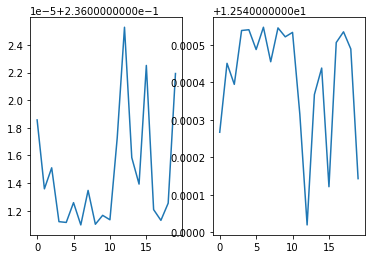

Error_Mean: 0.2360146674426054
Error_SD: 4.193249518594388e-06
ERLE_Mean: 12.540410454849658
ERLE_SD: 0.00015431966687975024


In [43]:
ERROR_opt_weight = []
ERLE_opt_weight = []
for i in range(20):
    error_opt_weight = []
    for n in range (filter_order-1, speech_desired.shape[0]):
        error_opt_weight.append(speech_desired[n] - np.dot(WEIGHT_OPT[i], speech_noisy[n-filter_order+1:n+1][::-1]))
    error_opt_weight = np.array(error_opt_weight)
    ERROR_opt_weight.append(np.sqrt(np.sum(error_opt_weight ** 2)/np.sum(speech_desired ** 2)))
    ERLE_opt_weight.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_opt_weight ** 2)))
    
# Plot misadjustment
ax1 = plt.subplot(1,2,1)
ax1.plot(ERROR_opt_weight)
ax2 = plt.subplot(1,2,2)
ax2.plot(ERLE_opt_weight)
plt.show()
print('Error_Mean:', np.mean(np.array(ERROR_opt_weight)))
print('Error_SD:', np.std(np.array(ERROR_opt_weight)))
print('ERLE_Mean:', np.mean(np.array(ERLE_opt_weight)))
print('ERLE_SD:', np.std(np.array(ERLE_opt_weight)))

In [44]:
# Calculate Misadjustment, under different filter orders (2-11)

step_size = 0.05

WEIGHT_store = []
ERROR_store = []
ERLE_store = []
WEIGHT_OPT = []
ERROR_mean_sd = []
ERLE_mean_sd = []
ERROR_opt_weight = []
ERLE_opt_weight = []

for mm in range (10):
    filter_order = mm + 2
    WEIGHT_store.append([])
    ERROR_store.append([])
    ERLE_store.append([])
    WEIGHT_OPT.append([])
    ERROR_opt_weight.append([])
    ERLE_opt_weight.append([])
    
    for i in range(20):

        weight_filter = np.random.normal(0, 0.1, filter_order)
        WEIGHT_store[mm].append(weight_filter)
        error_store = []

        for n in range (filter_order-1, speech_desired.shape[0]):
            e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
            weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
            y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
            error_store.append(y_error)

        error_store = np.array(error_store)
        ERROR_store[mm].append(np.sum(error_store ** 2)/np.sum(speech_desired ** 2))
        ERLE_store[mm].append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2)))
        WEIGHT_OPT[mm].append(weight_filter)
        
        # use the optimal weight to calculate error
        error_opt_weight = []
        for n in range (filter_order-1, speech_desired.shape[0]):
            error_opt_weight.append(speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1]))
        error_opt_weight = np.array(error_opt_weight)
        ERROR_opt_weight[mm].append(np.sqrt(np.sum(error_opt_weight ** 2)/np.sum(speech_desired ** 2)))
        ERLE_opt_weight[mm].append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_opt_weight ** 2)))
    
    ERROR_mean_sd.append([np.mean(ERROR_opt_weight[mm]), np.std(ERROR_opt_weight[mm])])
    ERLE_mean_sd.append([np.mean(ERLE_opt_weight[mm]), np.std(ERLE_opt_weight[mm])])


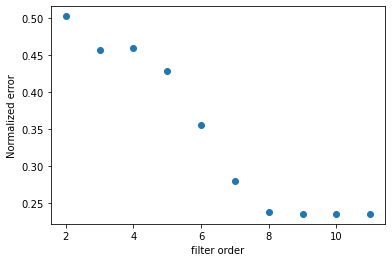

In [45]:
# Plot Errorbar Normalized Error
order_filter_array = np.arange(2,12)
plt.errorbar(order_filter_array, np.array(ERROR_mean_sd)[:, 0], yerr = np.array(ERROR_mean_sd)[:, 1], fmt ='o')
plt.xlabel('filter order')
plt.ylabel('Normalized error')
plt.show()

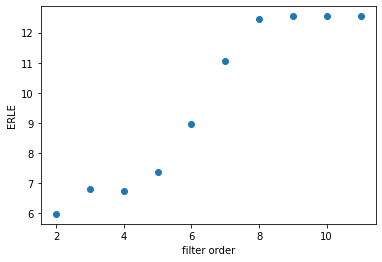

In [46]:
# Plot Errorbar ERLE
order_filter_array = np.arange(2,12)
plt.errorbar(order_filter_array, np.array(ERLE_mean_sd)[:, 0], yerr = np.array(ERLE_mean_sd)[:, 1], fmt ='o')
plt.xlabel('filter order')
plt.ylabel('ERLE')
plt.show()

237.55280104529578


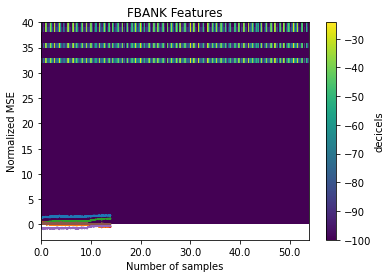

In [8]:
# APA Family (APA1)

sample_size = 50

step_size = 0.005

weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA1_store = []
error_APA1_store = []

for start in range(int((speech_desired.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([speech_noisy[start*sample_size+i:start*sample_size+i+filter_order][::-1] for i in range(sample_size)])
    window_filter_y = np.array([speech_desired[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = weight_filter + step_size * window_filter_x.T @ (window_filter_y - window_filter_x @ weight_filter)
    
    weight_APA1_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = np.sum((y_hat-window_filter_y) ** 2) / np.sum((window_filter_y) ** 2)
    error_APA1_store.append(y_error)
    

speech_APA1_filter = []
for i in range (int((speech_desired.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        speech_APA1_filter.append(np.dot(weight_APA1_store[i], speech_noisy[i*sample_size:i*sample_size+filter_order][::-1]))
speech_APA1_filter = np.array(speech_APA1_filter)

# plotsound
l1 = sp.plotsound(speech_APA1_filter, sr = fs)
plt.show()

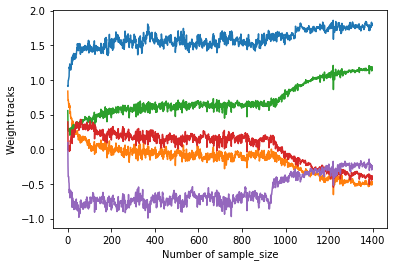

In [9]:
# APA1 
# weight
plt.plot(np.arange(len(weight_APA1_store)), weight_APA1_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

237.55280104529578


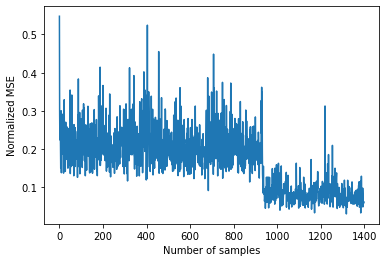

In [10]:
# APA1
# error
plt.plot(np.arange(len(error_APA1_store)), error_APA1_store)
plt.xlabel('Number of samples')
plt.ylabel('Normalized MSE')
plt.show()
print(np.sum(np.array(error_APA1_store)))

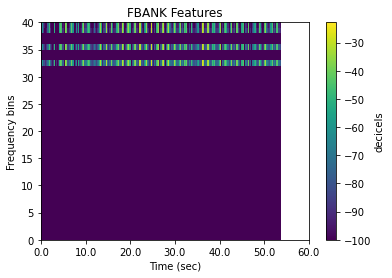

In [12]:
# APA Family (APA2)

step_size = 0.005

delta = 0.001
add_item = np.eye(sample_size) * delta

weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA2_store = []
error_APA2_store = []

for start in range(int((speech_desired.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([speech_noisy[start*sample_size+i:start*sample_size+i+filter_order][::-1] for i in range(sample_size)])
    window_filter_y = np.array([speech_desired[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = weight_filter + step_size * window_filter_x.T @ np.linalg.inv(window_filter_x @ window_filter_x.T + add_item) @ (window_filter_y - window_filter_x @ weight_filter)
    
    weight_APA2_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = np.sum((y_hat-window_filter_y) ** 2) / np.sum((window_filter_y) ** 2)
    error_APA2_store.append(y_error)
    

speech_APA2_filter = []
for i in range (int((speech_desired.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        speech_APA2_filter.append(np.dot(weight_APA2_store[i], speech_noisy[i*sample_size:i*sample_size+filter_order][::-1]))
speech_APA2_filter = np.array(speech_APA2_filter)
l2 = sp.plotsound(speech_APA2_filter, sr = fs)
plt.show()

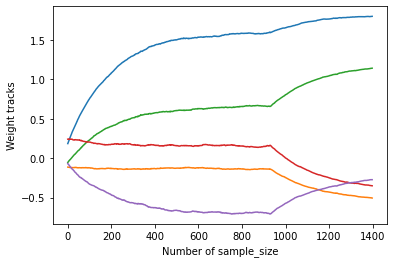

In [13]:
# APA2
# weight
plt.plot(np.arange(len(weight_APA2_store)), weight_APA2_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

308.5812194392559


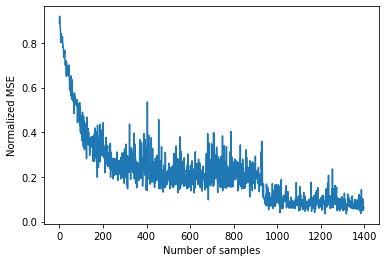

In [18]:
# APA2
# error
plt.plot(np.arange(len(error_APA2_store)), error_APA2_store)
plt.xlabel('Number of samples')
plt.ylabel('Normalized MSE')
plt.show()
print(np.sum(np.array(error_APA2_store)))

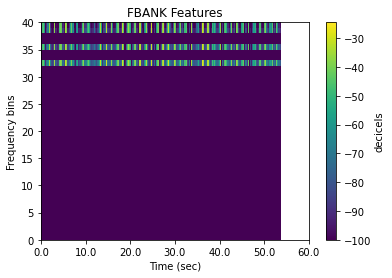

In [16]:
# APA Family (APA3)

step_size = 0.005

lamda = 10
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA3_store = []
error_APA3_store = []

for start in range(int((speech_desired.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([speech_noisy[start*sample_size+i:start*sample_size+i+filter_order][::-1] for i in range(sample_size)])
    window_filter_y = np.array([speech_desired[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = (1-step_size * lamda) * weight_filter + step_size * window_filter_x.T @ (window_filter_y - window_filter_x @ weight_filter)
    
    weight_APA3_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = np.sum((y_hat-window_filter_y) ** 2) / np.sum((window_filter_y) ** 2)
    error_APA3_store.append(y_error)
    

speech_APA3_filter = []
for i in range (int((speech_desired.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        speech_APA3_filter.append(np.dot(weight_APA3_store[i], speech_noisy[i*sample_size:i*sample_size+filter_order][::-1]))
speech_APA3_filter = np.array(speech_APA3_filter)

# plotsound
l3 = sp.plotsound(speech_APA3_filter, sr = fs)
plt.show()

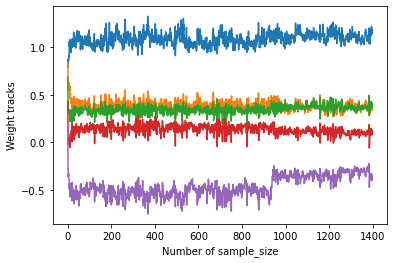

In [17]:
# APA3
# weight
plt.plot(np.arange(len(weight_APA3_store)), weight_APA3_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

273.15871547254187


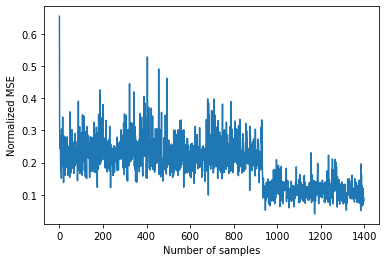

In [19]:
# APA3
# error
plt.plot(np.arange(len(error_APA3_store)), error_APA3_store)
plt.xlabel('Number of samples')
plt.ylabel('Normalized MSE')
plt.show()
print(np.sum(np.array(error_APA3_store)))

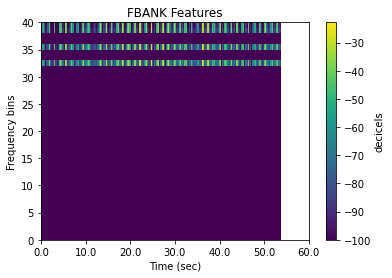

In [20]:
# APA Family (APA4)

step_size = 0.005

delta = 0.001
add_item = np.eye(sample_size) * delta

weight_filter = np.random.normal(0, 0.1, filter_order)

weight_APA4_store = []
error_APA4_store = []

for start in range(int((speech_desired.shape[0]-filter_order)/sample_size)):
    window_filter_x = np.array([speech_noisy[start*sample_size+i:start*sample_size+i+filter_order][::-1] for i in range(sample_size)])
    window_filter_y = np.array([speech_desired[start*sample_size+i+filter_order] for i in range(sample_size)])
    
    weight_filter = (1 - step_size) * weight_filter + step_size * window_filter_x.T @ np.linalg.inv(window_filter_x @ window_filter_x.T + add_item) @ window_filter_y
    
    weight_APA4_store.append(weight_filter)

    y_hat = np.matmul(window_filter_x, weight_filter)
    y_error = np.sum((y_hat-window_filter_y) ** 2) / np.sum((window_filter_y) ** 2)
    error_APA4_store.append(y_error)
    

speech_APA4_filter = []
for i in range (int((speech_desired.shape[0]-filter_order)/sample_size)):
    for j in range (sample_size):
        speech_APA4_filter.append(np.dot(weight_APA4_store[i], speech_noisy[i*sample_size:i*sample_size+filter_order][::-1]))
speech_APA4_filter = np.array(speech_APA4_filter)

# plotsound
l4 = sp.plotsound(speech_APA4_filter, sr = fs)
plt.show()

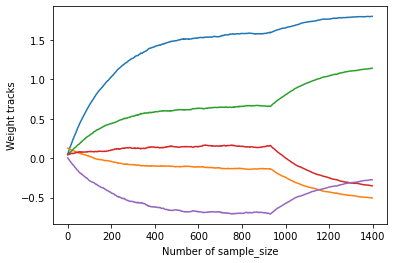

In [21]:
# APA4
# weight
plt.plot(np.arange(len(weight_APA4_store)), weight_APA4_store)
plt.xlabel('Number of sample_size')
plt.ylabel('Weight tracks')
plt.show()

302.2124882225567


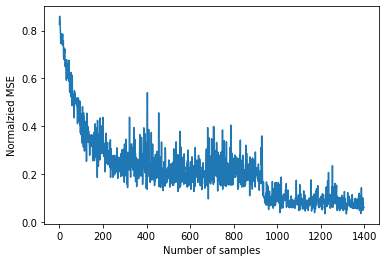

In [22]:
# APA4
# error
plt.plot(np.arange(len(error_APA4_store)), error_APA4_store)
plt.xlabel('Number of samples')
plt.ylabel('Normalzied MSE')
plt.show()
print(np.sum(np.array(error_APA4_store)))